<a href="https://colab.research.google.com/github/linked0/deep-learning/blob/master/batch-norm/Batch_Normalization_Lesson_181015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tqdm

In [2]:
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [3]:
# Import necessary packages
import tensorflow as tf
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import MNIST data so we have something for out experiments
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
class NeuralNet:
  def __init__(self, initial_weights, activation_fn, use_batch_norm):
    # Keep track of whether or not this network uses batch normalization.
    self.use_batch_norm = use_batch_norm
    self.name = 'With Batch Norm' if use_batch_norm else 'Without Batch Norm'
    
    # Batch normalization needs to do different calculations during training and inference,
    # so we use this placeholder to tell the graph which behavior to use.
    self.is_training = tf.placeholder(tf.bool, name='is_training')
    
    self.training_accuracies = []
    
    self.build_network(initial_weights, activation_fn)
    
  def build_network(self, initial_weights, activation_fn):
    self.input_layer = tf.placeholder(tf.float32, [None, initial_weights[0].shape[0]])
    layer_in = self.input_layer
    for weights in initial_weights[:-1]:
      layer_in = self.fully_connected(layer_in, weights, activation_fn)
    self.output_layer = self.fully_connected(layer_in, initial_weights[-1])
  
  def fully_connected(self, layer_in, initial_weights, activation_fn=None):
    if self.use_batch_norm and activation_fn:
      weights = tf.Variable(initial_weights)
      linear_output = tf.matmul(layer_in, weights)
      
      batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
      
      return activation_fn(batch_normalized_output)
    
    else:
      weights = tf.Variable(initial_weights)
      biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
      linear_output = tf.add(tf.matmul(layer_in, weights), biases)
      return linear_output if not activation_fn else activation_fn(linear_output)
    
  def train(self, session, learning_rate, training_batches, batches_per_sample, save_model_as=None):
    """
    Trains the model on the MNIST training dataset
    
    :param session: SEssion
      Used to run training graph operation
    :param learning_rate: float
      Learning rate used during gradient descent.
    :param training_batches: int
      Number of batches to train.
    :param batches_per_sample: int
      How many batches to train before sampling the validation accuracy.
    :param save_model_as: string or None (default None)
      Name to use if you want to save the trained model.
    """
    
    # This placeholder will store the target labels for each mini batch
    labels = tf.placeholder(tf.float32, [None, 10])
    
    # Define loass and optimizaer
    cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=self.output_layer))
    
    # Define operation for testing
    correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    if self.use_batch_norm:
      with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    else:
      train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    
    # Train for the appropriate number of batches. (tqdm is only for a nice timing display)
    for i in tqdm.tqdm(range(training_batches)):
      # We use batches of 60 just because the original paper did. You can use any size batch you like
      batch_xs, batch_ys = mnist.train.next_batch(60)
      session.run(train_step, feed_dict={self.input_layer: batch_xs,
                                        labels: batch_ys,
                                        self.is_training: True})
      
      # Periodically test accuracy against the 5k validation images and store it for plotting later.
      if i % batches_per_sample == 0:
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                        labels: mnist.validation.labels,
                                                        self.is_training: False})
        self.training_accuracies.append(test_accuracy)
        
    # After training, report accuracy against test data
    test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                    labels: mnist.validation.labels,
                                                    self.is_training: False})
    print('{}: After training, fanal accuracy on validaion set = {}'.format(self.name, test_accuracy))
    
    # If you want to use this model later for inference instead of having to retrain it,
    # just construct it with the same parameters and then pass this file to the 'test' function
    if save_model_as:
      tf.train.Saver().save(session, save_model_as)
    
  def test(self, session, test_training_accuracy=False, include_individual_predictions=False, restore_from=None):
    """
    Trains a trained model on the MNIST testing dataset.
    
    :param session: Session
      Used to run the testing graph operations.
    :param test_training_accurcay: bool (default False)
      If True, perform inference with batch normalization using batch mean and varicance;
      if False, perform inference with batch nomalization using estimated population mean and variance.
      Note: in real life, *always* perform inference using the population mean and variance
        This parameter exists just to support demostrating what happens if you don't
    :param include_individual_predictions: bool (default True)
    :param restore_from: string or None (default None)
      Name of a saved model if you want to test with previously saved weights.
    """
    # This placeholder will store the true labels for each mini batch
    labels = tf.placeholder(tf.float32, [None, 10])
    
    # Define operations for testing
    correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # If proveded, restore from a previously saved model
    if restore_from:
      tf.train.Saver().restore(session, restore_from)
      
    # Test against all of the MNIST test data
    test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                    labels: mnist.test.labels,
                                                    self.is_training: test_training_accuracy})
    print('-'*75)
    print('{}: Accuracy on full test set = {}'.format(self.name, test_accuracy))
    
    # If requested, perform tests predicting individual values rather than batches
    if include_individual_predictions:
      predictions = []
      correct = 0
      
      # Do 200 predictions, 1 at a time
      for i in range(200):
        # This is a normal prediction using an individual test case. However, notice
        # we pass 'test_training_accuracy' to 'feed_dict' as the value for 'self.is_training'.
        # Remember that will tell it whether it should use the batch mean & variance or
        # the populatio estimates that were calculated while training the model
        pred, corr = session.run([tf.arg_max(self.output_layer, 1), accuracy],
                                feed_dict={self.input_layer: [mnist.test.images[i]],
                                          labels:[mnint.test.labels[i]],
                                          self.is_traing: test_training_accuracy})
        correst += corr
        predictions.append(pred[0])
      print('200 Predcitions:', predictions)
      print('Accuracy on 200 samples:', correct/200)
  
    
    

# Batch Normalization Demos

## Code to support testing
The following two functions support the demos we run in the notebook.
The first function, `plot_training_accuracies`, simply plots the values found in the `training_accuracies` lists of the NeuralNet objects passed to it. If you look at the `train` function in `NerualNet`, you'll see it that while it's training the network, it periodically measures validation accuracy and stores the results in that list. It does that just to support these plots.

The second function, `train_and_test`, creates two neural nts - one with and one without batch normalization. It then trains them both and tests them, calling `plot_training_accuracies` to plot how their accuracies changed over the course tof training. The really important thing about this function is that it initializes the starting weights for the networks outside of the networks and then passes them in. This lets it train both networks from the exact same starting weights, which eliminates performance differences that might result from (un) lucky initial weights.

In [0]:
## Code to support testing

In [0]:
def plot_training_accuracies(*args, **kwargs):
  """
  Display a plot of the accuracies calculated during training to demonstrate how many iterations it took for the model(s) to converge.
  """
  fig, ax = plt.subplots()
  batches_per_sample = kwargs['batches_per_sample']
  
  for nn in args:
    ax.plot(range(0, len(nn.training_accuracies)*batches_per_sample, batches_per_sample),
            nn.training_accuracies, label=nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.0, 0.1))
    plt.grid(True)
    plt.show()
    
def train_and_test(use_bad_weights, learning_rate, activation_fn, training_batches=50000, batches_per_sample=500):
  """
  Creates two networks, one with and one without batch normalization, then trains them
  with identical strating weights, layers, batches, etc. Finally tests and plots their accuracies.
  """
  
  if use_bad_weights:
    weights = [np.random.normal(size=(784,100), scale=5.0).astype(np.float32),
              np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
              np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
              np.random.normal(size=(100,10), scale=5.0).astype(np.float32)]
  else:
    weights = [np.random.normal(size=(784,100), scale=0.5).astype(np.float32), 
              np.random.normal(size=(100,100), scale=0.5).astype(np.float32),
              np.random.normal(size=(100,100), scale=0.5).astype(np.float32),
              np.random.normal(size=(100,10), scale=0.5).astype(np.float32)]
  
  # Just to make sure the TensorFlow's default graph i empty before we start another
  # test, because we don't bother using different graphs or scoping and naming
  # elements carefully in this sample code.
  tf.reset_default_graph()
  
  # build two versions of same network, 1 without and 1 with batch normalization
  nn = NeuralNet(weights, activation_fn, False)
  bn = NeuralNet(weights, activation_fn, True)
  
  # train and test the two models
  with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    nn.train(sess, learning_rate, training_batches, batches_per_sample)
    bn.train(sess, learning_rate, training_batches, batches_per_sample)
    
    nn.test(sess)
    bn.test(sess)
    
  plot_training_accuracies(nn, bn, batches_per_sample=batches_per_sample)

## Comparisions between identical networks, with and without batch normalization
The next series of cells train networks with various settings to show the differences with and without batch normalization. They are meant to clearly demonstrate the effects of batch normalization. We include a deeper discussion of batch normalization later in the notebook.

### The following creates two networks using a ReLU activation function, a learning rate of 0.01, and reasonable starting weights

100%|██████████| 50000/50000 [02:23<00:00, 347.62it/s]


Without Batch Norm: After training, fanal accuracy on validaion set = 0.9423999786376953


100%|██████████| 50000/50000 [05:42<00:00, 146.07it/s]


With Batch Norm: After training, fanal accuracy on validaion set = 0.9520000219345093
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9390000104904175
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9470999836921692


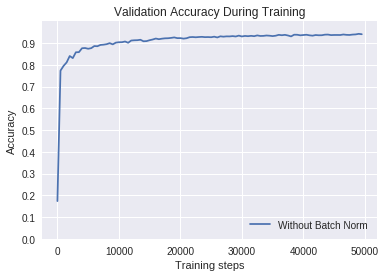

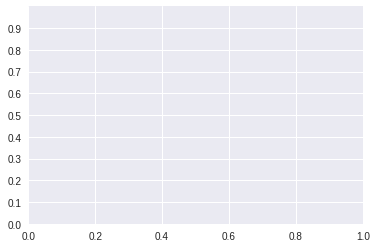

In [29]:
train_and_test(False, 0.01, tf.nn.relu)